# Exploratory Data Analysis

This notebook loads and explores the four CSVs in `data/` for basic structure, missingness, distributions, and quick cross-tabs.

In [252]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:0.2f}")

In [253]:
data_dir = Path("..") / "data"
players_path = data_dir / "players.csv"
player_games_path = data_dir / "player_games.csv"
vgsales_path = data_dir / "vgsales.csv"
reviews_path = data_dir / "video_game_reviews.csv"

players = pd.read_csv(players_path)
player_games = pd.read_csv(player_games_path)
vgsales = pd.read_csv(vgsales_path)
reviews = pd.read_csv(reviews_path)

players.shape, player_games.shape, vgsales.shape, reviews.shape

((1000, 4), (35412, 9), (16598, 11), (47774, 18))

## Players
- Demographics and session behavior by `age_group`.
- Look at missingness, distribution of sessions per week, and session length.

In [254]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   1000 non-null   int64  
 1   age_group                 1000 non-null   object 
 2   session_count_per_week    1000 non-null   int64  
 3   avg_session_length_hours  1000 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 31.4+ KB


In [255]:
players.describe(include="all")

,user_id,age_group,session_count_per_week,avg_session_length_hours
count,1000.00,1000,1000.00,1000.00
unique,NaN,4,NaN,NaN
top,NaN,Teens,NaN,NaN
freq,NaN,263,NaN,NaN
mean,500.50,NaN,5.65,2.02
std,288.82,NaN,3.32,0.68
min,1.00,NaN,2.00,0.50
25%,250.75,NaN,3.00,1.55
50%,500.50,NaN,5.00,2.01
75%,750.25,NaN,7.00,2.51


In [256]:
players['age_group'].value_counts()

age_group
Teens       263
Adults      254
Kids        242
All Ages    241
Name: count, dtype: int64

In [257]:
players.groupby('age_group')[['session_count_per_week', 'avg_session_length_hours']].agg(['mean','median','min','max'])

session_count_per_week                avg_session_length_hours  \
                            mean median min max                     mean   
age_group                                                                  
Adults                      5.82   5.00   2  14                     1.98   
All Ages                    5.39   4.00   2  14                     2.05   
Kids                        5.66   5.00   2  14                     2.07   
Teens                       5.70   5.00   2  14                     2.00   

                            
          median  min  max  
age_group                   
Adults      1.94 0.50 4.14  
All Ages    1.99 0.50 4.12  
Kids        2.06 0.50 4.16  
Teens       2.02 0.50 3.67

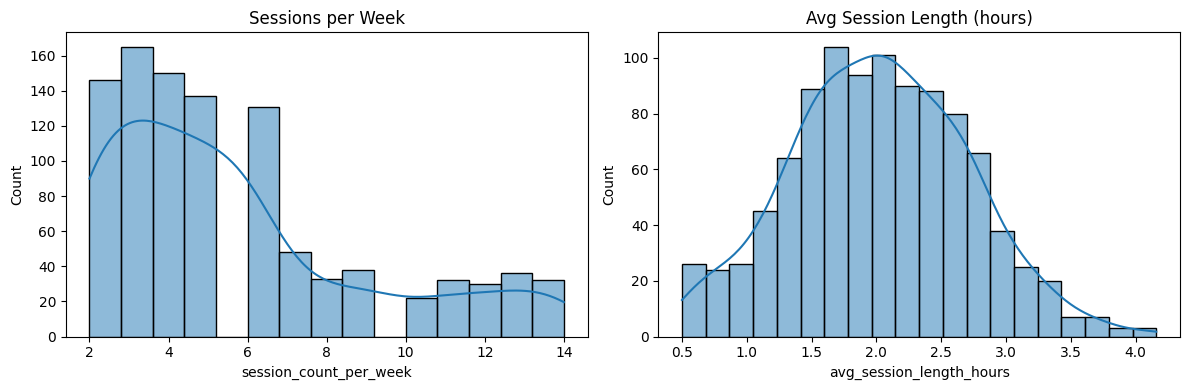

In [258]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(players['session_count_per_week'], kde=True, ax=axes[0])
axes[0].set_title('Sessions per Week')
sns.histplot(players['avg_session_length_hours'], kde=True, ax=axes[1])
axes[1].set_title('Avg Session Length (hours)')
plt.tight_layout()

## Player Games
- Game-level play history per user: platform/genre splits, multiplayer, playtime, price vs rating.

In [259]:
player_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35412 entries, 0 to 35411
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  35412 non-null  int64  
 1   game_title               35412 non-null  object 
 2   platform                 35412 non-null  object 
 3   genre                    35412 non-null  object 
 4   multiplayer              35412 non-null  object 
 5   requires_special_device  35412 non-null  object 
 6   price                    35412 non-null  float64
 7   playtime_hours           35412 non-null  float64
 8   player_rating            35412 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 2.4+ MB


In [260]:
player_games.describe(include='all')

,user_id,game_title,platform,genre,multiplayer,requires_special_device,price,playtime_hours,player_rating
count,35412.00,35412,35412,35412,35412,35412,35412.00,35412.00,35412.00
unique,NaN,40,5,10,2,2,NaN,NaN,NaN
top,NaN,Pokémon Scarlet & Violet,Mobile,Puzzle,No,No,NaN,NaN,NaN
freq,NaN,958,7286,3759,17817,17788,NaN,NaN,NaN
mean,499.01,NaN,NaN,NaN,NaN,NaN,38.74,7.39,2.74
std,289.11,NaN,NaN,NaN,NaN,NaN,11.54,4.57,0.74
min,1.00,NaN,NaN,NaN,NaN,NaN,19.99,0.50,1.00
25%,245.00,NaN,NaN,NaN,NaN,NaN,28.71,4.33,2.24
50%,496.00,NaN,NaN,NaN,NaN,NaN,37.91,6.70,2.73
75%,754.00,NaN,NaN,NaN,NaN,NaN,48.56,9.55,3.23


In [261]:
player_games[['platform','genre','multiplayer','requires_special_device']].nunique()

platform                    5
genre                      10
multiplayer                 2
requires_special_device     2
dtype: int64

In [262]:
player_games['platform'].value_counts().head()

platform
Mobile             7286
PlayStation        7217
Nintendo Switch    7147
PC                 7000
Xbox               6762
Name: count, dtype: int64

In [263]:
player_games['genre'].value_counts().head()

genre
Puzzle        3759
Shooter       3733
Strategy      3628
RPG           3603
Simulation    3600
Name: count, dtype: int64

In [264]:
player_games['multiplayer'].value_counts()

multiplayer
No     17817
Yes    17595
Name: count, dtype: int64

In [265]:
player_games[['price','player_rating']].corr()

,price,player_rating
price,1.00,-0.03
player_rating,-0.03,1.00


In [266]:
player_games.groupby('platform')['playtime_hours'].mean().sort_values(ascending=False).head()

platform
Nintendo Switch   7.50
Xbox              7.43
Mobile            7.37
PC                7.35
PlayStation       7.32
Name: playtime_hours, dtype: float64

/var/folders/ps/dp2pv5c94mgd208r06lxs13r0000gn/T/ipykernel_10766/1569542911.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')


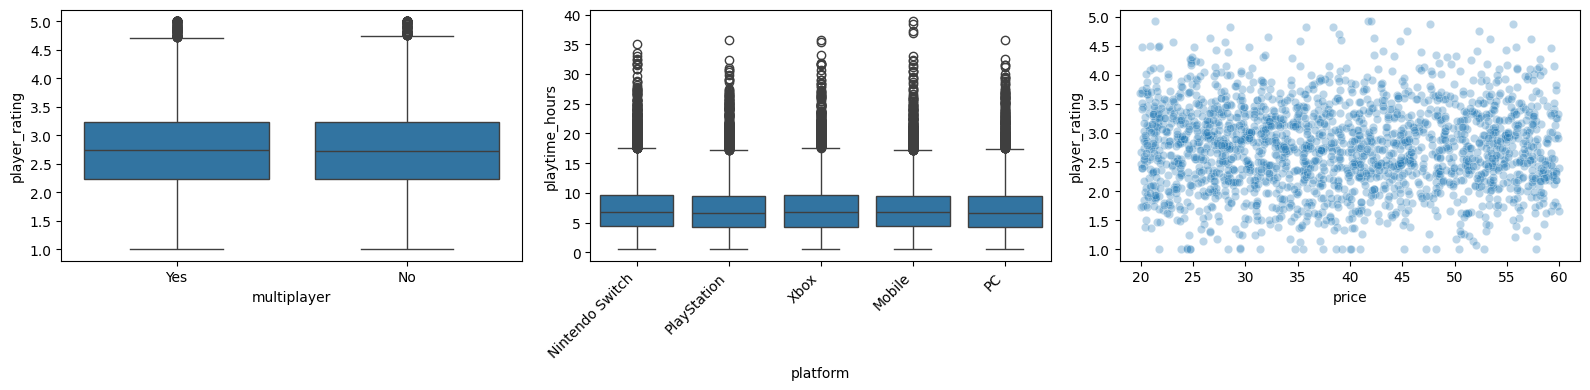

In [267]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
sns.boxplot(data=player_games, x='multiplayer', y='player_rating', ax=axes[0])
sns.boxplot(data=player_games, x='platform', y='playtime_hours', ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
sns.scatterplot(data=player_games.sample(min(2000, len(player_games))), x='price', y='player_rating', alpha=0.3, ax=axes[2])
plt.tight_layout()

## Video Game Sales
- Global sales by platform/genre; missingness in `Year` and `Publisher`; sales trends over years.

In [268]:
vgsales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [269]:
vgsales.isna().sum()

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

In [270]:
vgsales.describe(include='all')

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16598.00,16598,16598,16327.00,16598,16540,16598.00,16598.00,16598.00,16598.00,16598.00
unique,NaN,11493,31,NaN,12,578,NaN,NaN,NaN,NaN,NaN
top,NaN,Need for Speed: Most Wanted,DS,NaN,Action,Electronic Arts,NaN,NaN,NaN,NaN,NaN
freq,NaN,12,2163,NaN,3316,1351,NaN,NaN,NaN,NaN,NaN
mean,8300.61,NaN,NaN,2006.41,NaN,NaN,0.26,0.15,0.08,0.05,0.54
std,4791.85,NaN,NaN,5.83,NaN,NaN,0.82,0.51,0.31,0.19,1.56
min,1.00,NaN,NaN,1980.00,NaN,NaN,0.00,0.00,0.00,0.00,0.01
25%,4151.25,NaN,NaN,2003.00,NaN,NaN,0.00,0.00,0.00,0.00,0.06
50%,8300.50,NaN,NaN,2007.00,NaN,NaN,0.08,0.02,0.00,0.01,0.17
75%,12449.75,NaN,NaN,2010.00,NaN,NaN,0.24,0.11,0.04,0.04,0.47


In [271]:
vgsales['Platform'].value_counts().head()

Platform
DS      2163
PS2     2161
PS3     1329
Wii     1325
X360    1265
Name: count, dtype: int64

In [272]:
vgsales['Genre'].value_counts().head()

Genre
Action          3316
Sports          2346
Misc            1739
Role-Playing    1488
Shooter         1310
Name: count, dtype: int64

In [273]:
vgsales.groupby('Platform')['Global_Sales'].median().sort_values(ascending=False).head()

Platform
NES    1.38
GB     1.17
2600   0.46
SNES   0.32
X360   0.28
Name: Global_Sales, dtype: float64

In [274]:
annual_sales = vgsales.dropna(subset=['Year']).groupby('Year')['Global_Sales'].mean()
annual_sales.tail()

Year
2014.00   0.58
2015.00   0.43
2016.00   0.21
2017.00   0.02
2020.00   0.29
Name: Global_Sales, dtype: float64

/var/folders/ps/dp2pv5c94mgd208r06lxs13r0000gn/T/ipykernel_10766/816246375.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')


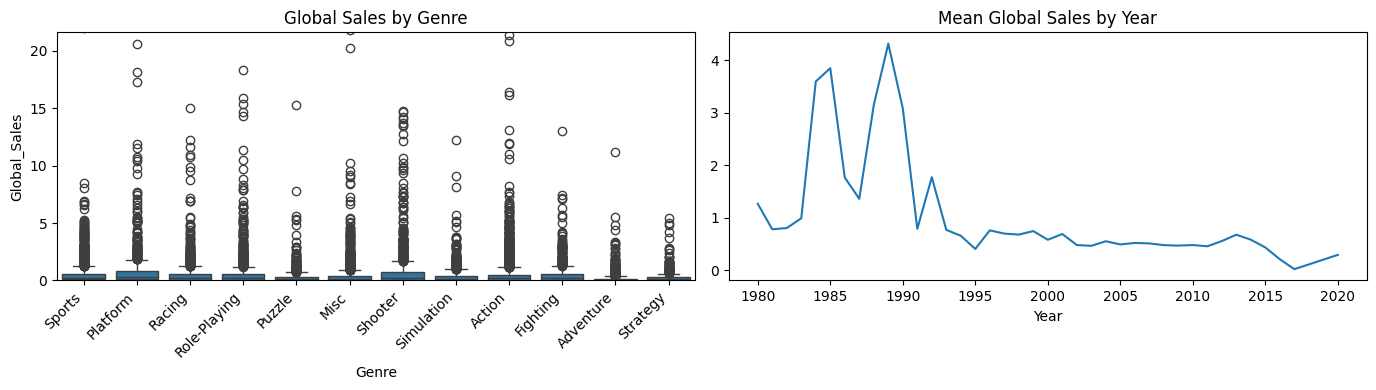

In [275]:
fig, axes = plt.subplots(1, 2, figsize=(14,4))
sns.boxplot(data=vgsales, x='Genre', y='Global_Sales', ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_ylim(0, annual_sales.max()*5)
axes[0].set_title('Global Sales by Genre')
annual_sales.plot(ax=axes[1])
axes[1].set_title('Mean Global Sales by Year')
plt.tight_layout()

## Video Game Reviews
- User ratings, pricing, target age groups, and content quality ratings; multiplayer/game mode splits.

In [276]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47774 entries, 0 to 47773
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Game Title               47774 non-null  object 
 1   User Rating              47774 non-null  float64
 2   Age Group Targeted       47774 non-null  object 
 3   Price                    47774 non-null  float64
 4   Platform                 47774 non-null  object 
 5   Requires Special Device  47774 non-null  object 
 6   Developer                47774 non-null  object 
 7   Publisher                47774 non-null  object 
 8   Release Year             47774 non-null  int64  
 9   Genre                    47774 non-null  object 
 10  Multiplayer              47774 non-null  object 
 11  Game Length (Hours)      47774 non-null  float64
 12  Graphics Quality         47774 non-null  object 
 13  Soundtrack Quality       47774 non-null  object 
 14  Story Quality         

In [277]:
reviews.describe(include='all')

,Game Title,User Rating,Age Group Targeted,Price,Platform,Requires Special Device,Developer,Publisher,Release Year,Genre,Multiplayer,Game Length (Hours),Graphics Quality,Soundtrack Quality,Story Quality,User Review Text,Game Mode,Min Number of Players
count,47774,47774.00,47774,47774.00,47774,47774,47774,47774,47774.00,47774,47774,47774.00,47774,47774,47774,47774,47774,47774.00
unique,40,NaN,4,NaN,5,2,10,9,NaN,10,2,NaN,4,4,4,12,2,NaN
top,Pokémon Scarlet & Violet,NaN,Teens,NaN,PlayStation,No,Bungie,Capcom,NaN,RPG,No,NaN,High,Excellent,Poor,"Great game, but the graphics could be better.",Offline,NaN
freq,1274,NaN,12038,NaN,9633,23887,4877,5406,NaN,4873,24090,NaN,12113,12036,12041,4067,23957,NaN
mean,NaN,29.72,NaN,39.95,NaN,NaN,NaN,NaN,2016.48,NaN,NaN,32.48,NaN,NaN,NaN,NaN,NaN,5.12
std,NaN,7.55,NaN,11.52,NaN,NaN,NaN,NaN,4.03,NaN,NaN,15.87,NaN,NaN,NaN,NaN,NaN,2.77
min,NaN,10.10,NaN,19.99,NaN,NaN,NaN,NaN,2010.00,NaN,NaN,5.00,NaN,NaN,NaN,NaN,NaN,1.00
25%,NaN,24.30,NaN,29.99,NaN,NaN,NaN,NaN,2013.00,NaN,NaN,18.80,NaN,NaN,NaN,NaN,NaN,3.00
50%,NaN,29.70,NaN,39.84,NaN,NaN,NaN,NaN,2016.00,NaN,NaN,32.50,NaN,NaN,NaN,NaN,NaN,5.00
75%,NaN,35.10,NaN,49.96,NaN,NaN,NaN,NaN,2020.00,NaN,NaN,46.30,NaN,NaN,NaN,NaN,NaN,7.00


In [278]:
reviews[['Age Group Targeted','Platform','Genre','Multiplayer','Game Mode']].nunique()

Age Group Targeted     4
Platform               5
Genre                 10
Multiplayer            2
Game Mode              2
dtype: int64

In [279]:
reviews['Age Group Targeted'].value_counts()

Age Group Targeted
Teens       12038
Kids        12013
All Ages    11954
Adults      11769
Name: count, dtype: int64

In [280]:
reviews['Platform'].value_counts().head()

Platform
PlayStation        9633
PC                 9599
Nintendo Switch    9596
Mobile             9589
Xbox               9357
Name: count, dtype: int64

In [281]:
reviews['Genre'].value_counts().head()

Genre
RPG           4873
Shooter       4869
Strategy      4867
Puzzle        4822
Simulation    4784
Name: count, dtype: int64

In [282]:
reviews[['Price','User Rating']].corr()

,Price,User Rating
Price,1.00,0.76
User Rating,0.76,1.00


In [283]:
reviews.groupby('Age Group Targeted')['User Rating'].mean()

Age Group Targeted
Adults     29.70
All Ages   29.81
Kids       29.66
Teens      29.70
Name: User Rating, dtype: float64

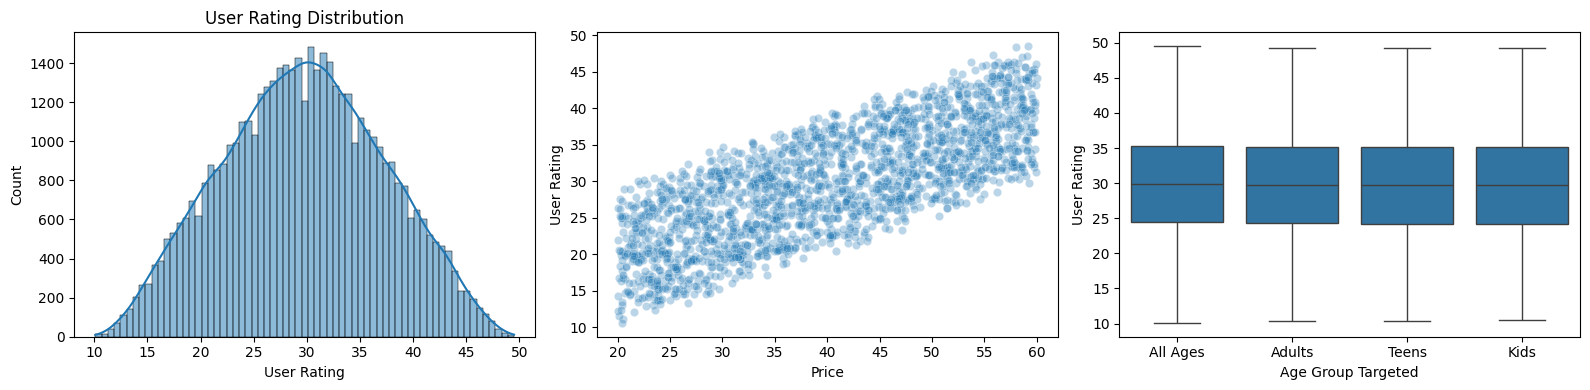

In [284]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
sns.histplot(reviews['User Rating'], kde=True, ax=axes[0])
axes[0].set_title('User Rating Distribution')
sns.scatterplot(data=reviews.sample(min(2000, len(reviews))), x='Price', y='User Rating', alpha=0.3, ax=axes[1])
sns.boxplot(data=reviews, x='Age Group Targeted', y='User Rating', ax=axes[2])
plt.tight_layout()


## Joined Sales + Reviews
- Inner join `vgsales.Name` with `reviews['Game Title']`; drop rows missing in either dataset or with any NA after join.


In [285]:
# Ensure required columns exist
common = reviews.rename(columns={'Game Title': 'Name'})
joined = vgsales.merge(common, on='Name', how='inner')
joined_clean = joined.dropna()
joined_shape = joined_clean.shape
joined_shape


(42399, 28)


## Aggregated Reviews by Game
- Collapse multiple reviews per title to a single row using mean for numeric fields and mode/first for categorical fields; also add review count.


In [286]:
# Aggregate review data per game title
numeric_cols = ['User Rating', 'Price', 'Release Year', 'Game Length (Hours)', 'Min Number of Players']
categorical_cols = ['Age Group Targeted','Platform','Requires Special Device','Developer','Publisher','Genre','Multiplayer','Graphics Quality','Soundtrack Quality','Story Quality','Game Mode']
def mode_or_first(series):
    m = series.mode(dropna=True)
    if not m.empty:
        return m.iloc[0]
    cleaned = series.dropna()
    return cleaned.iloc[0] if not cleaned.empty else None
agg_map = {col: 'mean' for col in numeric_cols}
agg_map.update({col: mode_or_first for col in categorical_cols})
# Keep the first review text as a representative snippet
agg_map['User Review Text'] = 'first'
aggregated_reviews = reviews.groupby('Game Title').agg(agg_map)
aggregated_reviews['review_count'] = reviews.groupby('Game Title').size()
aggregated_reviews.head()


,User Rating,Price,Release Year,Game Length (Hours),Min Number of Players,Age Group Targeted,Platform,Requires Special Device,Developer,Publisher,Genre,Multiplayer,Graphics Quality,Soundtrack Quality,Story Quality,Game Mode,User Review Text,review_count
Game Title,,,,,,,,,,,,,,,,,,
1000-Piece Puzzle,29.85,39.88,2016.46,32.99,5.09,Teens,Mobile,Yes,Capcom,Electronic Arts,Party,No,High,Average,Poor,Offline,"Solid game, but the graphics could be better.",1222
Among Us,29.70,39.99,2016.43,32.32,5.11,All Ages,PC,Yes,Valve,Nintendo,Simulation,Yes,Low,Poor,Poor,Online,"Disappointing game, but the graphics could be ...",1127
Animal Crossing: New Horizons,29.94,40.59,2016.53,32.27,5.18,All Ages,PC,No,Nintendo,Activision,RPG,No,Ultra,Excellent,Excellent,Offline,"Solid game, but the gameplay is amazing.",1208
Bioshock Infinite,29.54,39.74,2016.46,32.35,4.94,All Ages,Xbox,No,Bungie,Nintendo,Puzzle,No,Ultra,Excellent,Good,Offline,"Solid game, but the graphics could be better.",1141
Call of Duty: Modern Warfare 2,29.91,40.32,2016.45,32.45,5.16,Kids,PlayStation,Yes,Bungie,Valve,Fighting,Yes,Ultra,Average,Average,Online,"Disappointing game, but the gameplay is amazing.",1208


## Summary of EDA and Preprocessing Work
- Loaded four datasets from `data/` (`players`, `player_games`, `vgsales`, `video_game_reviews`).
- Explored each dataset: `info()`, `describe()`, value counts, grouped stats, correlations, and several plots (histograms/boxplots/scatter/trend lines).
- Joined sales and reviews on `Name` vs `Game Title` with inner join and dropped rows with any missing values (`joined_clean`).
- Aggregated reviews per game title: averaged numeric fields, took mode/first for categoricals, kept first review text, and added `review_count` (`aggregated_reviews`).



## TODO
- Set up a video game recommendation model with Surprise (e.g., SVD or KNNBaseline) using user/game ratings so we can suggest unseen games to each player.
- Document install/import steps for Surprise in the notebook and evaluate with a train/test split (RMSE), plus a helper to fetch top-N recommendations per user.
